In [ ]:
#!pip install tensorflow librosa

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JorgeRuizDev/SpotMyFM/blob/main/Ludwig/notebooks/gtzan/gtzan_demo_train.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/JorgeRuizDev/SpotMyFM/blob/main/Ludwig/notebooks/gtzan/gtzan_demo_train.ipynb)

In [ ]:
# Imports
import tensorflow as tf
from tensorflow.python.keras.api import keras
from tensorflow.python.keras.api.keras.preprocessing.image import ImageDataGenerator

import os
from pathlib import Path
from IPython.core.display import HTML, display

import librosa
import random
import numpy as np
from math import floor
from typing import Union, Any

In [ ]:
def download():
  #!pip install kaggle
  import os
  os.environ['KAGGLE_USERNAME'] = "jorgeruizdev"
  os.environ['KAGGLE_KEY'] = "5f3badd86b1d1035e2723792a67a2879"
  !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
  !unzip -qq /content/gtzan-dataset-music-genre-classification.zip
#download()

In [ ]:
print(tf. __version__)
print(tf.config.list_physical_devices('GPU'))


In [ ]:
# CONFIG

SAMPLE_RATE = 22050

TRACK_LENGTH = 30

TRACK_SAMPLES = 22050 * TRACK_LENGTH

SPLITS = 4

SAMPLES_PER_SPLIT = TRACK_SAMPLES // SPLITS

N_MELS = 64

print(f"Samples Per Split {SAMPLES_PER_SPLIT}")

# Dataset:
DATASET_PATH = "/content/Data"

GENRES_PATH = f"{DATASET_PATH}/genres_original"

GENRES = os.listdir(GENRES_PATH)



# Training
BATCH_SIZE = 20


In [ ]:
GENRE_2_LABEL = {k: v for v, k in enumerate(GENRES)}
LABEL_2_GENRE = {v: k for k,v in GENRE_2_LABEL.items()}
print(f"Genre to Label Dict: {GENRE_2_LABEL}")
print(f"Label to Genre Dict: {LABEL_2_GENRE}")

In [ ]:
if not len(list(Path(f"{DATASET_PATH}/genres_original/disco").glob("*.wav"))) >= 100:
  print(f"""
    No subfolder 'genres_original/disco' found under {DATASET_PATH}.
    Please download the datasate from https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification and
    unzip it under {DATASET_PATH}.
  """)
  raise IOError


In [ ]:
def split_track(signal, splits = 5):
    samples_per_split = len(signal) // splits
    max_split = samples_per_split * splits

    return np.array_split(signal[:max_split], splits)



In [ ]:
def normalize_mfccs(mfcc_feat: np.ndarray):
    return np.subtract(mfcc_feat,np.mean(mfcc_feat))


In [ ]:
def preprocess_track(signal: Union[np.ndarray, Any], sr=SAMPLE_RATE):
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=N_MELS, sr=sr)

    #log_S = librosa.amplitude_to_db(mfccs)
    #delta = librosa.feature.delta(mfccs, order=1)

    return normalize_mfccs(mfccs)

In [ ]:
def load_data(genre_path=GENRES_PATH):
    track_input = []
    labels = []
    for genre in GENRES:
        genre_folder = f"{genre_path}/{genre}"
        label = GENRE_2_LABEL[genre]
        for track in os.listdir(genre_folder):

            if (track == "jazz.00054.wav"):
                # This track is broken 
                continue

            y, sr = librosa.load(f"{genre_folder}/{track}", sr=SAMPLE_RATE)
            
            # Split into chunkso f SAMPLES_PER_SPLIT length 
            splits = [y[slice_samp:slice_samp + SAMPLES_PER_SPLIT] for slice_samp in range(0, len(y), SAMPLES_PER_SPLIT) ]

            track = []

            for split in splits:
                
                if (len(split) == SAMPLES_PER_SPLIT):
                    track.append(preprocess_track(split, sr))
            
            if len(track):  
                track_input.append(track)
                labels.append(label)

    

    return track_input, labels

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b), f"len(a) = {len(a)} != len(b) = {len(b)}"
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [157]:
tracks_, labels_ = load_data()

In [158]:
def train_test_val(ds, test=0.1, val=0.2):


    train_slice = floor(len(ds) * (1 - val + test))


    train = ds[:train_slice]
    rest = ds[train_slice:]

    rest_slice =  floor(len(rest) * (1 - (test / ( test + val))))

    test = rest[:rest_slice]
    val = rest[rest_slice:]

    return train, test, val


In [159]:

class TrackDataGen(keras.utils.Sequence):
    
    def __init__(self, data,
                 input_shape = (13, 259),
                 batch_size = 30):
        
        self.batch_size = batch_size
        self.shape = input_shape
        X = []
        Y = []

        for track_splits, labels in data:
            X.extend(track_splits)
            Y.extend(([labels]* len(track_splits)))

        X_np = np.array(X)
        X_np = np.expand_dims(X_np, axis=3)
        Y_np = np.array(Y)

        self.X, self.Y = unison_shuffled_copies(X_np, Y_np)
        
    
    
    def on_epoch_end(self):
        pass
    
    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size:(idx + 1) * self.batch_size] 
        
        return batch_x, np.array(batch_y)
    
    def __len__(self):
        return len(self.X) // self.batch_size

In [160]:
tracks, labels = tracks_, labels_


track_labels = list(zip(tracks, labels))

random.shuffle(track_labels)

train, test, val = train_test_val(track_labels)
print(len(train) + len(test) + len(val))


train_generator = TrackDataGen(train)
print(train_generator[0][0].shape)
validation_generator = TrackDataGen(val)




990
(30, 64, 1292, 1)


In [161]:
model = keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), activation=keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (5,5), activation=keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (5,5), activation=keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),                                       
    
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation=keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(128, activation=keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(10, activation='softmax'),  
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator,
                     validation_data = validation_generator, 
                     #validation_steps = len(tracks) // BATCH_SIZE,
                     epochs=100 
                     )

Epoch 1/100
29/29 [==============================] - 5s 140ms/step - loss: 3.7559 - accuracy: 0.1345 - val_loss: 2.2192 - val_accuracy: 0.0333
Epoch 2/100
29/29 [==============================] - 4s 130ms/step - loss: 2.1334 - accuracy: 0.2103 - val_loss: 1.9117 - val_accuracy: 0.2000
Epoch 3/100
29/29 [==============================] - 4s 129ms/step - loss: 2.0365 - accuracy: 0.2862 - val_loss: 1.5153 - val_accuracy: 0.3667
Epoch 4/100
29/29 [==============================] - 4s 130ms/step - loss: 1.8137 - accuracy: 0.3310 - val_loss: 1.4835 - val_accuracy: 0.5000
Epoch 5/100
29/29 [==============================] - 4s 128ms/step - loss: 1.7276 - accuracy: 0.3770 - val_loss: 1.4558 - val_accuracy: 0.5667
Epoch 6/100
29/29 [==============================] - 4s 130ms/step - loss: 1.6913 - accuracy: 0.4391 - val_loss: 1.7446 - val_accuracy: 0.3333
Epoch 7/100
29/29 [==============================] - 4s 129ms/step - loss: 1.2319 - accuracy: 0.5885 - val_loss: 1.7640 - val_accuracy: 0.5333

In [166]:

test_generator = TrackDataGen(test)
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

2/2 [==============================] - 0s 63ms/step - loss: 18.2420 - accuracy: 0.3667
test loss, test acc: [18.242033004760742, 0.36666667461395264]


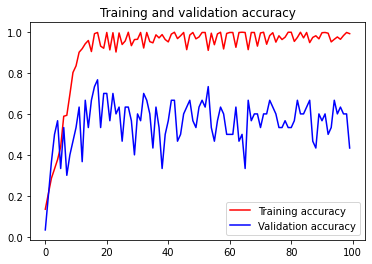

<Figure size 432x288 with 0 Axes>

In [163]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
import requests
from IPython import display
url = input()
r = requests.get(url, allow_redirects=True)
open('test.mp3', 'wb').write(r.content)

Y, sr = librosa.load('test.mp3')

track = preprocess_track(Y, sr)

pred = model.predict(np.expand_dims([track], axis=3))
print(pred)
print(LABEL_2_GENRE.get(np.argmax(pred)))

display.Audio("test.mp3")